# Pregunta 1
Aplicar los conocimientos de las charlas en extender los conocimientos del curso estudiando un tópico.

## Librerias

In [1]:
from time import time
import numpy as np
import pandas as pd
import os
import nltk
from gensim.models.word2vec import Word2Vec
import sklearn
from matplotlib import pyplot as plt

C:\Users\paz_e\anaconda3\envs\tensorflow2\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Preprocesamiento
Se sacan todos los símbolos y se lleva todo el texto a minúsculas.

In [2]:
import re

def preprocesador(text):
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    text = text[:len(text)-1]
    return text

In [3]:
df=pd.read_csv(r'C:\Users\paz_e\Downloads\movies_reviews.csv')

In [4]:
#aplicamos preprocesador
start_time = time()
df['review'] = df['review'].apply(preprocesador)
elapsed_time = time() - start_time
print("Elapsed time: %0.10f seconds." % elapsed_time)

Elapsed time: 7.0190670490 seconds.


In [5]:
df

,review,sentiment
0,in 1974 the teenager martha moxley maggie grac...,1
1,ok so i really like kris kristofferson and his...,0
2,spoiler do not read this if you think about w...,0
3,hi for all the people who have seen this wonde...,1
4,i recently bought the dvd forgetting just how ...,0
...,...,...
49995,ok lets start with the best the building altho...,0
49996,the british heritage film industry is out of c...,0
49997,i don t even know where to begin on this one i...,0
49998,richard tyler is a little boy who is scared of...,0


## Tokenización usando TFIDF

In [6]:
#tokenizamos con casual_tokenize y vectorizamos con tfidf
start_time = time()
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize

#max_df=0.9 implica que no se tomarán en cuenta los tokens que aparezcan en más de 90% de las reviews
#min_df=0.002 implica que no se tomarán en cuenta los tokens que aparezcan en menos de 0.002*50.000=100 reviews
tfidf_model=TfidfVectorizer(tokenizer=casual_tokenize, max_df=0.9, min_df=0.002)

tfidf_docs = tfidf_model.fit_transform(raw_documents=df.review).toarray()

elapsed_time = time() - start_time
print("Elapsed time: %0.10f seconds." % elapsed_time)

Elapsed time: 77.4079902172 seconds.


#matriz x
tfidf_docs.shape

### 50.000 reviews con 6375 tokens

In [8]:
Prueba=tfidf_docs[:10]
#este vector es para hacer 10 predicciones al final del jupyter

## Train y Test

In [9]:
#¿Que es sentiment?
#Al parecer 1= les gustó la pelicula, 0=no les gustó la pelicula
#¿Cuantos 1 hay?, sumemos
cont=0
y=df['sentiment']
for i in range(0,50000):
  if y[i]==1:
    cont=cont+1
cont
#hay 25000 reviews positivas

25000

In [10]:
from sklearn.model_selection import train_test_split

x_train_MLP, x_test_MLP, y_train, y_test = train_test_split(tfidf_docs, df.sentiment, test_size=0.4, 
                                                    random_state=271828, stratify=df.sentiment)

In [11]:
x_train_MLP.shape

(30000, 6379)

In [12]:
print(len(x_train_MLP))
print(len(x_test_MLP))
print(len(y_train))
print(len(y_test))

30000
20000
30000
20000


## MLP

In [13]:
# compute the number of labels
num_labels = len(np.unique(y_train))
num_labels

2

In [14]:
from keras.utils import to_categorical
# llevamos los vectores a one hot
y_train_MLP = to_categorical(y_train)
y_test_MLP = to_categorical(y_test)

In [15]:
#tamaño de entrada
input_size = x_train_MLP.shape[1]

# parametros

batch_size = 256          #cantidad de datos usados para el metodo del gradiente    
hidden_units = 32         #numero de neuronas en capas ocultas
dropout = 0.45            #no se ajustaran el 45% de los pesos que menos afectaron en la propagación del error
epochs = 4                #cantidad de veces que pasan los datos 

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout


In [17]:
#arquitectura de la red
model1 = Sequential()
model1.add(Dense(hidden_units, input_dim=input_size))
model1.add(Activation('relu'))                            #función de activación relu: max(0,x)
model1.add(Dropout(dropout))
model1.add(Dense(num_labels))
model1.add(Activation('softmax'))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                204160    
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 204,226
Trainable params: 204,226
Non-trainable params: 0
_________________________________________________________________


## Comprobando como se calculan el número de parámetros

In [18]:
#dense =hidden units*(tokens+sesgo)
32*(6379+1)

204160

In [19]:
#dense_1=(hidden_dims+sesgo)*num_labels
(32+1)*2

66

## K-fold
Para probar que los resultados no están sesgados a la elección de train y test.

In [20]:
# se devuelven los vectores a su forma original
y_train=np.squeeze(np.asarray(y_train))
y_test=np.squeeze(np.asarray(y_test))

In [21]:
y_train

array([1, 1, 0, ..., 1, 0, 0], dtype=int64)

In [22]:
y_test

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                204160    
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total params: 204,226
Trainable params: 204,226
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
94/94 [==============================] - 1s 14ms/step - loss: 0.5839 - accuracy: 0.7743 - val_loss: 0.45

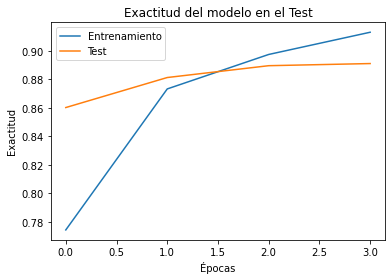

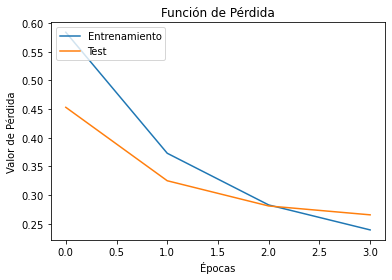

Fold:  1, Class dist.: [12000 12000], Acc: 0.895
Fold:  1, F1: 0.892
Fold:  1, Accuracy_: 0.891
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                204160    
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_5 (Activation)    (None, 2)                 0         
Total params: 204,226
Trainable params: 204,226
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
94/94 [=

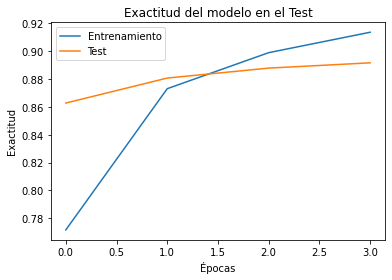

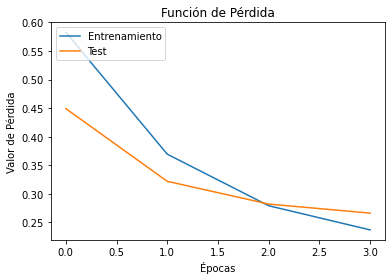

Fold:  2, Class dist.: [12000 12000], Acc: 0.892
Fold:  2, F1: 0.893
Fold:  2, Accuracy_: 0.892
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                204160    
_________________________________________________________________
activation_6 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_7 (Activation)    (None, 2)                 0         
Total params: 204,226
Trainable params: 204,226
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
94/94 [=

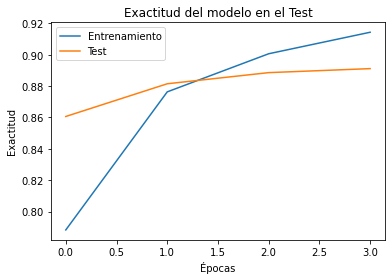

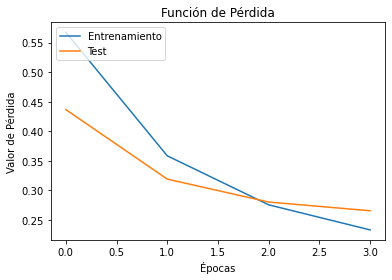

Fold:  3, Class dist.: [12000 12000], Acc: 0.894
Fold:  3, F1: 0.892
Fold:  3, Accuracy_: 0.891
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 32)                204160    
_________________________________________________________________
activation_8 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_9 (Activation)    (None, 2)                 0         
Total params: 204,226
Trainable params: 204,226
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
94/94 [=

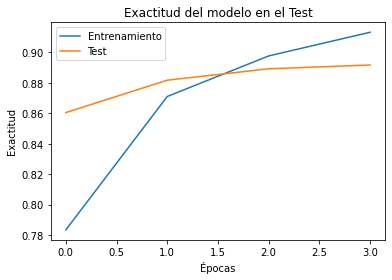

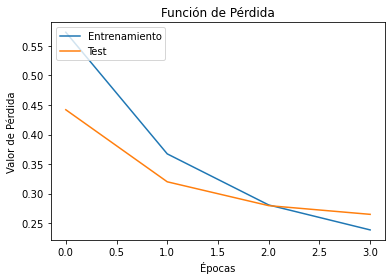

Fold:  4, Class dist.: [12000 12000], Acc: 0.897
Fold:  4, F1: 0.892
Fold:  4, Accuracy_: 0.892
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                204160    
_________________________________________________________________
activation_10 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 66        
_________________________________________________________________
activation_11 (Activation)   (None, 2)                 0         
Total params: 204,226
Trainable params: 204,226
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
94/94 [=

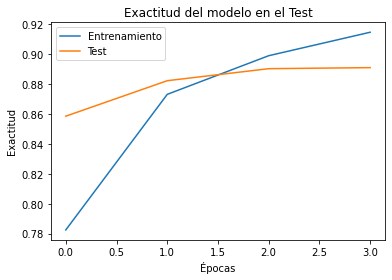

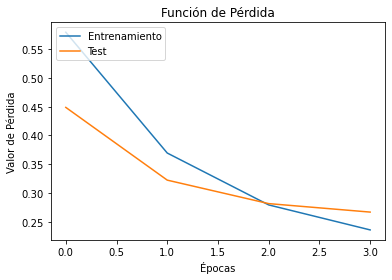

Fold:  5, Class dist.: [12000 12000], Acc: 0.892
Fold:  5, F1: 0.892
Fold:  5, Accuracy_: 0.891


In [23]:
from sklearn.model_selection import StratifiedKFold
#se hacen los folds
kfold = StratifiedKFold(n_splits=5).split(x_train_MLP,y_train)
#vectores para guardar los resultados
scores = []
f1s=[]
accs=[]
y_pred=[]
y_pruebas=[]
for k, (train, test) in enumerate(kfold):
    
    #INICIAR LA RED
    model1K = Sequential()
    model1K.add(Dense(hidden_units, input_dim=input_size))
    model1K.add(Activation('relu'))
    model1K.add(Dropout(dropout))
    model1K.add(Dense(num_labels))
    model1K.add(Activation('softmax'))
    model1K.summary()
    model1K.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history4=model1K.fit(x_train_MLP[train], y_train_MLP[train],  batch_size=batch_size, epochs=epochs, validation_data=(x_test_MLP, y_test_MLP))
    loss, score = model1K.evaluate(x_train_MLP[test], y_train_MLP[test])
    scores.append(score)
    
    #CALCULAR MÉTRICAS
    y_prueba=model1K.predict_classes(Prueba)    #10 predicciones de prueba
    y_pruebas.append(y_prueba)
    y_pred_MLP_Kfold = model1K.predict_classes(x_test_MLP)
    f1=sklearn.metrics.f1_score(y_test, y_pred_MLP_Kfold, average='binary')
    f1s.append(f1)
    acc=sklearn.metrics.accuracy_score(y_test, y_pred_MLP_Kfold)
    accs.append(acc)
    y_pred.append(y_pred_MLP_Kfold)
    
    #GRÁFICOS
    plt.plot(history4.history['accuracy'])
    plt.plot(history4.history['val_accuracy'])
    plt.title('Exactitud del modelo en el Test')
    plt.ylabel('Exactitud')
    plt.xlabel('Épocas')
    plt.legend(['Entrenamiento', 'Test'], loc='upper left')
    plt.show()
    
    plt.plot(history4.history['loss'])
    plt.plot(history4.history['val_loss'])
    plt.title('Función de Pérdida')
    plt.ylabel('Valor de Pérdida')
    plt.xlabel('Épocas')
    plt.legend(['Entrenamiento', 'Test'], loc='upper left')
    plt.show()
    
    # IMPRIMIR RESULTADOS
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,np.bincount(y_train[train]), score))
    print('Fold: %2d, F1: %.3f' % ((k+1), f1))
    print('Fold: %2d, Accuracy_: %.3f' % ((k+1), acc))


# Predicciones
Realizadas con la mejor red.

In [24]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


 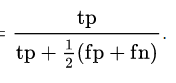

Accuracy_score = $\dfrac{tp+tn}{tp+fp+tn+fn}$

In [25]:
Prom_f1s=np.mean(f1s)
print(Prom_f1s)
f1s.append(Prom_f1s)

0.8921320425579278


In [26]:
Prom_accs=np.mean(accs)
print(Prom_accs)
accs.append(Prom_accs)

0.89133


In [27]:
f1s2=np.matrix(f1s)
accs2=np.matrix(accs)
Prom=(f1s2+accs2)/2

# Tabla comparativa

In [28]:
d = {'Fold':['1','2','3','4','5','Promedio'],'F1': f1s, 'Accuracy': accs, 'Promedio':Prom.T.tolist()}

df = pd.DataFrame(data=d)
df

,Fold,F1,Accuracy,Promedio
0,1,0.891768,0.89100,[0.8913842220236323]
1,2,0.893111,0.89170,[0.8924054678247137]
2,3,0.892007,0.89110,[0.8915535700119]
3,4,0.891799,0.89175,[0.8917743452946174]
4,5,0.891975,0.89110,[0.8915375012399563]
5,Promedio,0.892132,0.89133,[0.8917310212789639]


## Para esta red, el mejor fue el fold 2

# El módelo con mejor rendimiento fue MLP
Veamos 10 predicciones

In [43]:
# vector que contiene las predicciones del mejor k.fold de las 10 primeras reviews de la base (el fold 2, es el vector 
# en la posicion 1)
y_pruebas[1]

array([1, 0, 0, 1, 0, 1, 1, 1, 1, 1], dtype=int64)

In [30]:
df=pd.read_csv(r'C:\Users\paz_e\Downloads\movies_reviews.csv')

In [31]:
df[:10]

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
5,Leave it to Braik to put on a good show. Final...,1
6,Nathan Detroit (Frank Sinatra) is the manager ...,1
7,"To understand ""Crash Course"" in the right cont...",1
8,I've been impressed with Chavez's stance again...,1
9,This movie is directed by Renny Harlin the fin...,1


## Review 0: Sentimiento=1, predicción=1

In [32]:
df.review[0]

'In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />"Murder in Greenwich" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich famil

## Review 1: Sentimiento=0, predicción=0

In [33]:
df.review[1]

"OK... so... I really like Kris Kristofferson and his usual easy going delivery of lines in his movies. Age has helped him with his soft spoken low energy style and he will steal a scene effortlessly. But, Disappearance is his misstep. Holy Moly, this was a bad movie! <br /><br />I must give kudos to the cinematography and and the actors, including Kris, for trying their darndest to make sense from this goofy, confusing story! None of it made sense and Kris probably didn't understand it either and he was just going through the motions hoping someone would come up to him and tell him what it was all about! <br /><br />I don't care that everyone on this movie was doing out of love for the project, or some such nonsense... I've seen low budget movies that had a plot for goodness sake! This had none, zilcho, nada, zippo, empty of reason... a complete waste of good talent, scenery and celluloid! <br /><br />I rented this piece of garbage for a buck, and I want my money back! I want my 2 hou

## Review 2: Sentimiento=0, predicción=0

In [34]:
df.review[2]

'***SPOILER*** Do not read this, if you think about watching that movie, although it would be a waste of time. (By the way: The plot is so predictable that it does not make any difference if you read this or not anyway)<br /><br />If you are wondering whether to see "Coyote Ugly" or not: don\'t! It\'s not worth either the money for the ticket or the VHS / DVD. A typical "Chick-Feel-Good-Flick", one could say. The plot itself is as shallow as it can be, a ridiculous and uncritical version of the American Dream. The young good-looking girl from a small town becoming a big success in New York. The few desperate attempts of giving the movie any depth fail, such as the "tragic" accident of the father, the "difficulties" of Violet\'s relationship with her boyfriend, and so on. McNally (Director) tries to arouse the audience\'s pity and sadness put does not have any chance to succeed in this attempt due to the bad script and the shallow acting. Especially Piper Perabo completely fails in conv

## Review 3: Sentimiento=1, predicción=1

In [35]:
df.review[3]

'hi for all the people who have seen this wonderful movie im sure thet you would have liked it as much as i. i love the songs once you have seen the show you can sing along as though you are part of the show singing and dancing . dancing and singing. the song ONE is an all time fave musical song too and the strutters at the end with the mirror its so oh you have to watch this one'

## Review 4: Sentimiento=0, predicción=0

In [36]:
df.review[4]

'I recently bought the DVD, forgetting just how much I hated the movie version of "A Chorus Line." Every change the director Attenborough made to the story failed.<br /><br />By making the Director-Cassie relationship so prominent, the entire ensemble-premise of the musical sails out the window.<br /><br />Some of the musical numbers are sped up and rushed. The show\'s hit song gets the entire meaning shattered when it is given to Cassie\'s character.<br /><br />The overall staging is very self-conscious.<br /><br />The only reason I give it a 2, is because a few of the great numbers are still able to be enjoyed despite the film\'s attempt to squeeze every bit of joy and spontaneity out of it.'

## Review 5: Sentimiento=1, predicción=1

In [37]:
df.review[5]

"Leave it to Braik to put on a good show. Finally he and Zorak are living their own lives outside of Spac Ghost Coast To Coast. I have to say that I love both of these shows a whole lot. They are completely what started Adult Swim. Brak made it big with an album that came out in the year 2000. It may not have been platinum, but his show was really popular to tons of people out there that love Adult Swims shows. I have to say that out of all the Adult Swim shows with no plot, this has to be the one with the most none plot ever made. That is why I like it so much, it is just such a classic in the Adult Swim history. I believe this is just such a great show, if you don't like it. Hey there were tons who hated it and tons who loved it."

## Review 6: Sentimiento=1, predicción=1

In [38]:
df.review[6]

'Nathan Detroit (Frank Sinatra) is the manager of the New York\'s longest- established floating craps game, and he needs $1000 to secure a new location. Confident of his odds, he bets the city\'s highest-roller, Sky Masterson (Marlon Brando), that he can\'t woo uptight missionary Sarah Brown (Jean Simmons). \'Guys and Dolls (1955)\' is such a great musical because it deftly blends the contrasting styles of film and stage. During a dazzling opening sequence, crowds of pedestrians move in rhythm, stopping and starting as though responding to backstage cues. Even the walking movements themselves are stylised and angular, halfway between a walk and a dance. Mankiewicz\'s New York City is a glittering flurry of art deco colour and movement, a fantasy world so completely removed from reality that even the business of underground gambling and criminal thuggery seems perfectly genial. <br /><br />As I write this review, I\'ve just received word that Jean Simmons has passed away, age 80. This, 

## Review 7: Sentimiento=1, predicción=1

In [39]:
df.review[7]

'To understand "Crash Course" in the right context, you must understand the 80\'s in TV. Most TV shows didn\'t have any point. The sitcom outpopulated the drama at least 3 to 1. They were still figuring out where the lines were so that they could cross them. (TV Shows like "Hail to the Chief" was quite the bold step!) This made-for-TV movie "Crash Course" featured an All-Star cast, bringing together members from all the 80\'s classics: "227", "Family Ties", "Who\'s the Boss?", et al. Directors must\'ve had a certain penchant for those all-star movies then. Still, this movie offered very light fare and a simplistic view of heroism and maturity. And that\'s not bad sometimes. Viva Soleil Moon Frye.'

## Review 8: Sentimiento=1, predicción=1

In [40]:
df.review[8]

"I've been impressed with Chavez's stance against globalisation for sometime now, but it wasn't until I saw the film at the Amsterdam documentary international film festival that I realize what he has really achieved. This film tells the story of coup/conspiracy by Venezuela's elite, the oil companies and oil loving corrupt western governments, to remove democratically elected president Chavez, and return Venezuela back to a brutal dictatorship. This film is must for anyone who believes in freedom and justice, and is also a lesson to the rest of world ! I commend the people of Venezuela for taking matter into their own hands, and saving their country from the likes of Halliburton and the Bush regime."

## Review 9: Sentimiento=1, predicción=1

In [41]:
df.review[9]

'This movie is directed by Renny Harlin the finnish miracle. Stallone is Gabe Walker. Cat and Mouse on the mountains with ruthless terrorists. Renny Harlin knows how to direct actionmovie. Stallone needed this role to get back on track. Snowy mountain is very good place for action movie and who is better to direct movie where is snow, ice, cold and bad weather than finnish man. Action is good! Music in the film is spectacular. The bad guy is John Litghow, other stars Micheal Rooker ( The portrait of serialkiller), Janine Turner ( Strong Medicine). The is placed in beautiful place and it is very exciting movie. Overall good movie ****/*****<br /><br />Remember Extreme ääliöt: special collectors edition, with good extras. Comig soon in Finland straight to video.'